## Results analysis by dataset/dimension

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway, ttest_ind
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
from statsmodels.formula.api import ols
from scipy import stats

os.chdir("..")

from utils.results_utils import (
    plot_metrics,
    regression_vs_metric,
    calculate_correlations
)

In [ ]:
# load models performance metrics
output_dir = "data/output"
dataframes = {}

for file in os.listdir(output_dir):
    if file.endswith(".csv"):
        key = file.replace(".csv", "")

        file_path = os.path.join(output_dir, file)
        df = pd.read_csv(file_path)
        
        df = df.sort_values(by='vs')
        dataframes[key] = df

#### Performance metrics by diversity level

In [ ]:
def plot_metrics(df, name):
    """
    Plots MCC performance against diversity scores using points and a regression line.

    Args:
        df (pd.DataFrame): DataFrame containing metrics and diversity scores.
        name (str): Title for the plot.
    """
    # Set a color for MCC
    color = sns.color_palette("hls",8)[5]

    plt.figure(figsize=(8, 5))

    # Scatter plot for MCC
    plt.scatter(df['vs'], df['mcc'], color=color, label='MCC', edgecolor='black')

    # Compute and plot the regression line for MCC
    sns.regplot(x=df['vs'], y=df['mcc'], scatter=False, color=color, line_kws={'linewidth': 2, 'linestyle': '--'})

    # Set y-axis limit from 0 to 1
    plt.ylim(0, 1)

    # Add labels, title, and legend
    plt.xlabel(f'{name} (VS)', fontsize=16)
    plt.ylabel('MCC', fontsize=16)
    #plt.title(name, fontsize=14)
    #plt.legend(title='MCC', loc='upper left', fontsize=10)
    plt.tight_layout()

    slope, intercept, r_value, p_value, std_err = stats.linregress(df['vs'], df['mcc'])

        # Print regression coefficients
    print(f"{name} - Regression Coefficients:")
    print(f"Slope: {slope:.4f}")
    print(f"Intercept: {intercept:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"R-squared: {r_value**2:.4f}")
    
    # Show the plot
    plt.show()

results_annomatic_source - Regression Coefficients:
Slope: -0.0001
Intercept: 0.5597
P-value: 0.8232
R-squared: 0.0015


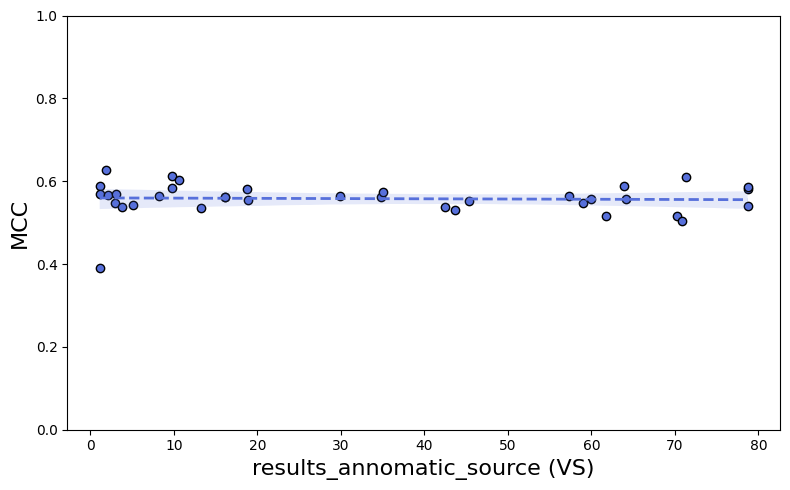

results_annomatic_topic - Regression Coefficients:
Slope: 0.0007
Intercept: 0.5450
P-value: 0.3114
R-squared: 0.0301


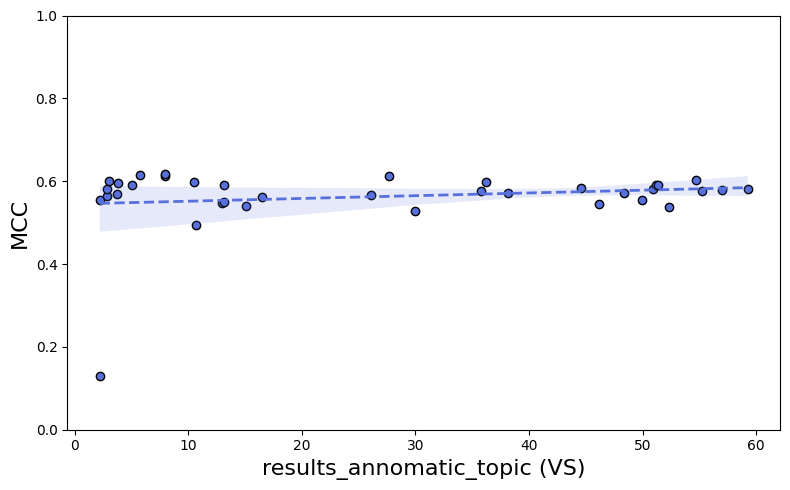

results_babe_source - Regression Coefficients:
Slope: 0.0102
Intercept: 0.5703
P-value: 0.1294
R-squared: 0.0663


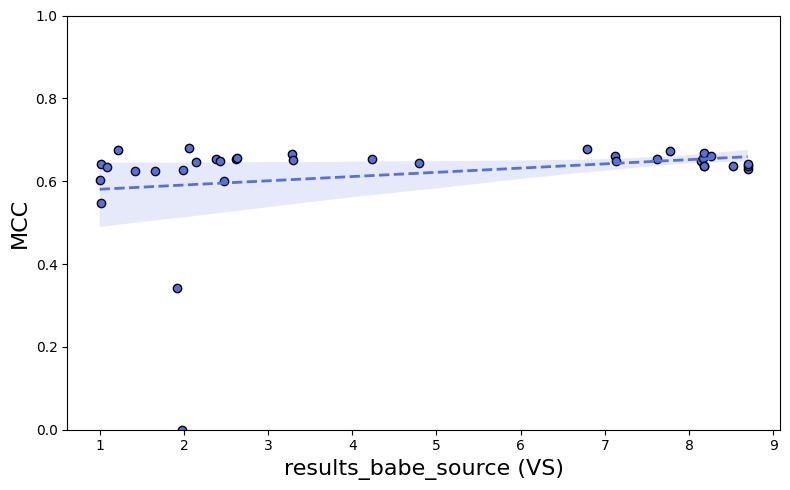

results_babe_topic - Regression Coefficients:
Slope: -0.0000
Intercept: 0.6233
P-value: 0.9775
R-squared: 0.0000


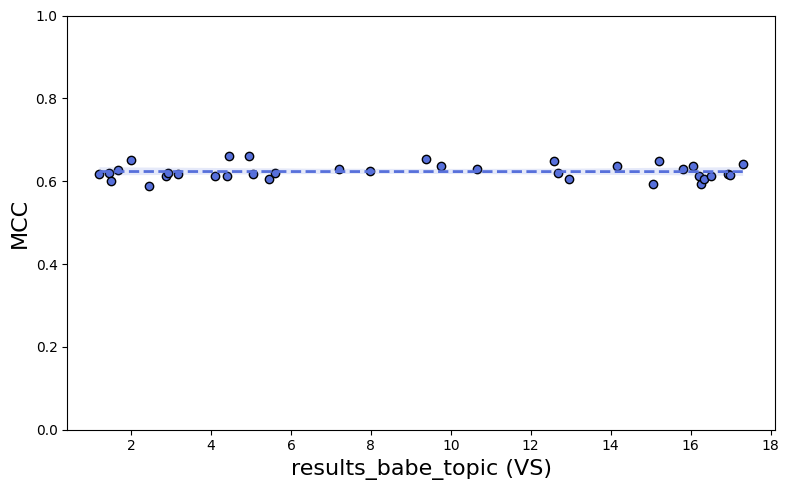

In [5]:
for name, subsample in dataframes.items():
    plot_metrics(subsample, name)

Test with Splines - do not assume linearity
Would lose the nice interpretability of linear regression and does not add so much

results_annomatic_source


C:\Users\sofik\AppData\Local\Temp\ipykernel_28752\605946231.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


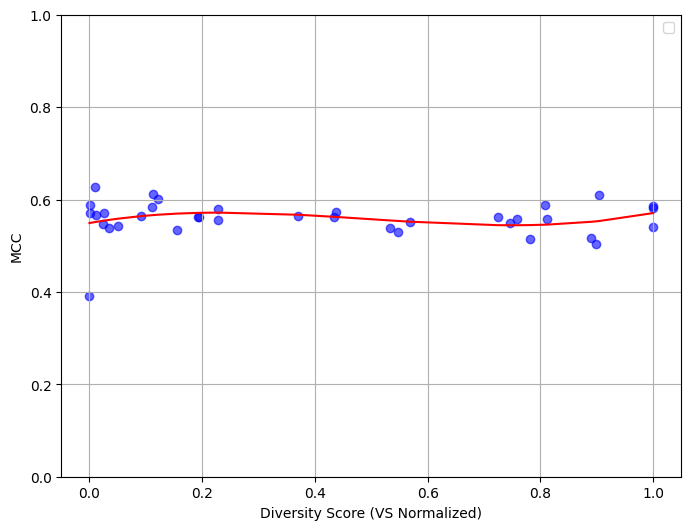

results_annomatic_topic


C:\Users\sofik\AppData\Local\Temp\ipykernel_28752\605946231.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


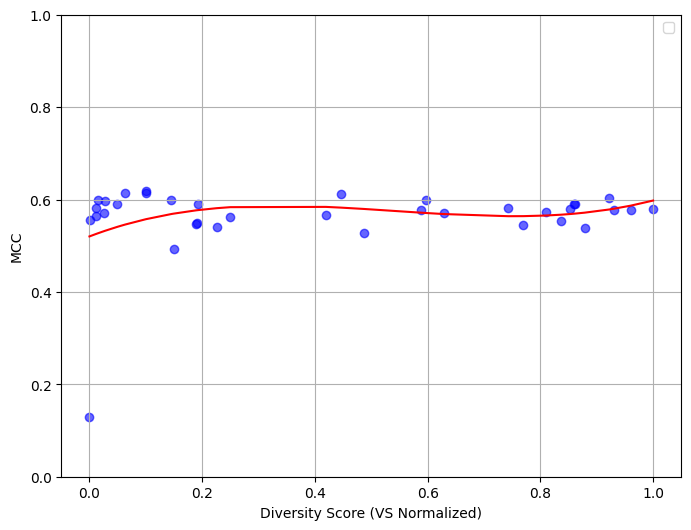

results_babe_source


C:\Users\sofik\AppData\Local\Temp\ipykernel_28752\605946231.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


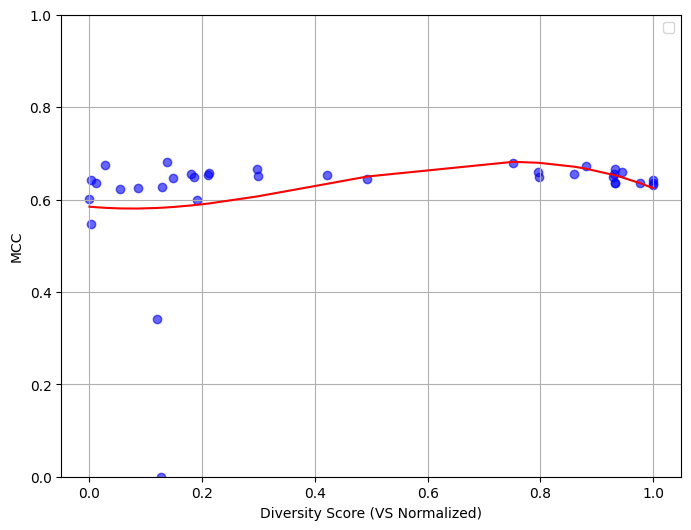

results_babe_topic


C:\Users\sofik\AppData\Local\Temp\ipykernel_28752\605946231.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


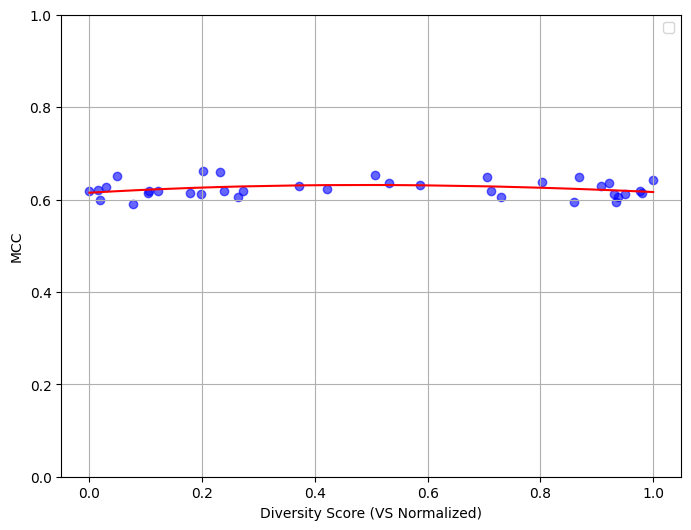

In [15]:
from scipy.interpolate import UnivariateSpline

def spline_reg(df):
    
    scaler = MinMaxScaler()
    df['vs'] = scaler.fit_transform(df[['vs']])

    # Fit spline regression
    spline_model = UnivariateSpline(df['vs'], df['mcc'], k=3)  # k=3 for cubic spline

    # Predict values using the spline model
    df['spline_pred'] = spline_model(df['vs'])

    # Plot the original data and the spline regression fit
    plt.figure(figsize=(8, 6))
    plt.scatter(df['vs'], df['mcc'], color='blue', alpha=0.6)
    plt.plot(df['vs'], df['spline_pred'], color='red')
    plt.xlabel("Diversity Score (VS Normalized)")
    plt.ylabel("MCC")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

for name, subsample in dataframes.items():
    print(name)
    spline_reg(subsample)

Correlations

In [16]:
for name, subsample in dataframes.items():
    print(f"{name}\n")
    print(f"{calculate_correlations(subsample)}\n")

results_annomatic_source

      Metric Pearson Corr.  Pearson P-value Spearman Corr.  Spearman P-value
0        mcc        -0.039         0.823246         -0.139          0.419969
1         f1         0.026         0.878499         -0.041          0.812024
2  precision        -0.189         0.268754         -0.193          0.259456
3     recall         0.287         0.089104          0.145          0.397752
4    roc_auc        -0.068         0.693686         -0.138          0.421715

results_annomatic_topic

      Metric Pearson Corr.  Pearson P-value Spearman Corr.  Spearman P-value
0        mcc         0.174         0.311448         -0.009          0.960187
1         f1         0.160         0.350185          0.001          0.993461
2  precision         0.151         0.378187          0.063          0.714228
3     recall        -0.144         0.402903         -0.175          0.307727
4    roc_auc         0.183         0.285576         -0.012          0.944758

results_babe_source

  

#### ANOVA test between low and high diversity groups

In [ ]:
# Create the grouping 

for name, df in dataframes.items():
    # normalize VS
    scaler = MinMaxScaler()
    df['vs_normalized'] = scaler.fit_transform(df[['vs']])

    group_labels = ['low', 'middle', 'high']

    # equal width bins. First 10%, last 10%
    df['diversity_group'] = pd.cut(df['vs_normalized'], bins=[-float('inf'),1/10, 9/10, float('inf')], labels=group_labels)


for key, df in dataframes.items():

    # Separate the groups
    low = df[df['diversity_group'] == 'low']['mcc']
    middle = df[df['diversity_group'] == 'middle']['mcc']
    high = df[df['diversity_group'] == 'high']['mcc']
    
    #ANOVA
    anova_result = f_oneway(low, high)
    print(f"{key}: F = {round(anova_result.statistic, 3)}, p = {round(anova_result.pvalue, 3)}")


results_annomatic_source: F = 0.791, p = 0.391
results_annomatic_topic: F = 0.426, p = 0.527
results_babe_source: F = 3.163, p = 0.096
results_babe_topic: F = 0.004, p = 0.953


C:\Users\sofik\AppData\Local\Temp\ipykernel_28752\137970340.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['diversity_group'] = df_filtered['diversity_group'].cat.remove_categories('middle')
C:\Users\sofik\AppData\Local\Temp\ipykernel_28752\137970340.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['category'] = 'source'
C:\Users\sofik\AppData\Local\Temp\ipykernel_28752\137970340.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

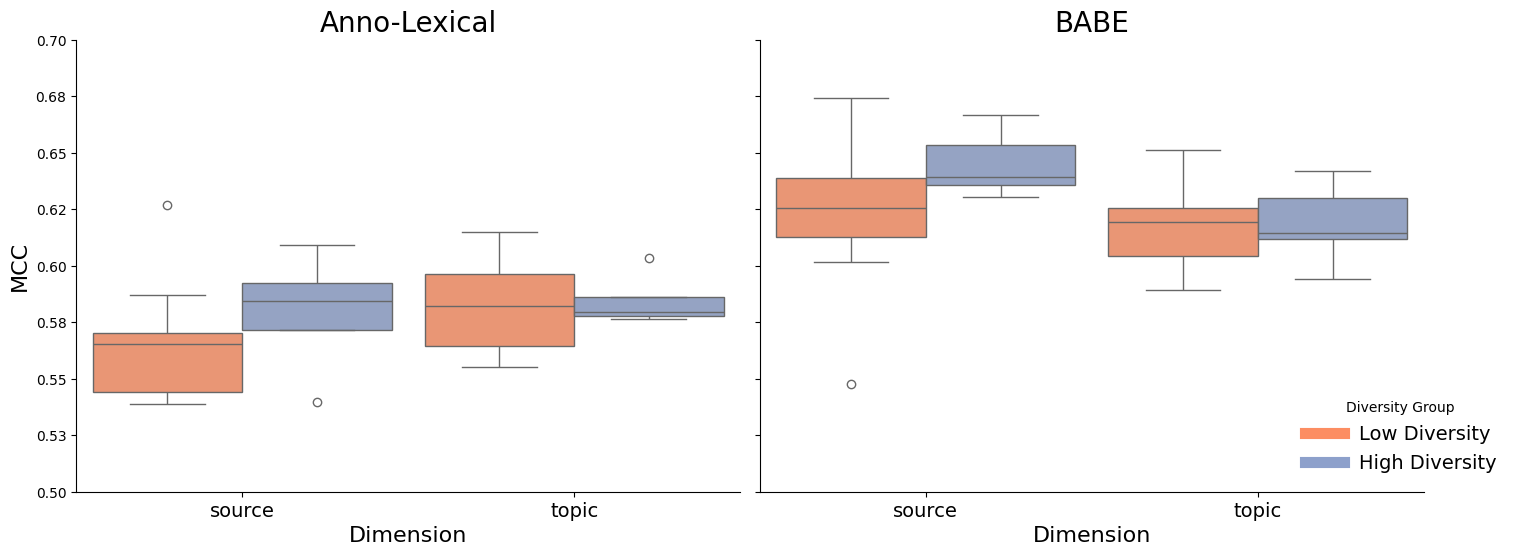

In [24]:
# Boxplot graph

all_datasets = []

for key, df in dataframes.items():
    
    if "annomatic" in key:
        df["dataset"] = "Anno-Lexical"
    elif "babe" in key:
        df["dataset"] = "BABE"

    # Filter only low and high diversity groups
    df_filtered = df[df['diversity_group'] != 'middle']
    df_filtered['diversity_group'] = df_filtered['diversity_group'].cat.remove_categories('middle')

    # Add a "category" column to differentiate "source" and "topic"
    if "source" in key:
        df_filtered['category'] = 'source'
    else:
        df_filtered['category'] = 'topic'

    all_datasets.append(df_filtered)

# Concatenate all datasets into one df
merged_df = pd.concat(all_datasets)


# BOXPLOT
g = sns.FacetGrid(merged_df, col="dataset", height=6, aspect=1.2)
selected_colors = sns.color_palette("Set2")[1:3]

g.map(sns.boxplot, "category", "mcc", "diversity_group", palette=selected_colors, width=0.9)
g.set_axis_labels("Dimension", "MCC", fontsize=16)
g.set_xticklabels(fontsize=14)
g.set(ylim=(0.5, 0.7)) # Reduce range to improve visualization
g.set_titles(col_template="{col_name}", fontsize=20)

for ax, title in zip(g.axes.flat, ["Anno-Lexical", "BABE"]):
    ax.set_title(title, fontsize=20)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Legend
legend_handles = [
    plt.Line2D([0], [0], color=selected_colors[0], lw=8, label='Low Diversity'),
    plt.Line2D([0], [0], color=selected_colors[1], lw=8, label='High Diversity')
]
g.add_legend(
    title="Diversity Group",
    handles=legend_handles,
    fontsize=14,
    title_fontsize=16,
    loc='lower center',
    bbox_to_anchor=(0.85, 0.1)  # (x, y)
)

plt.subplots_adjust(top=0.85)
plt.show()
